In [2]:
#This header file contains all the common packages

%run header.ipynb

In [25]:
phi_1d=np.load("/home/cz136/project/sa/data/{}/phi_1d.npy".format(dir_string))
phi_w_1d=np.load("/home/cz136/project/sa/data/{}/phi_1d.npy".format(dir_string))
e_list=np.load("/home/cz136/project/sa/data/{}/e_array.npy".format(dir_string))

FileNotFoundError: [Errno 2] No such file or directory: '/home/cz136/project/sa/data/vol_all/phi_1d.npy'

In [3]:
print(len(clusters))
print(len(shapes))

553
21621


In [4]:
def drop_poor_centers():
    """Drop clusters with no center shape data from the cluster dataframe"""
    center_id=clusters[('Alt', 'Alt1', 'ID_CENT')]
    pp=shapes.loc[center_id][('All','PP')].to_numpy()
    missing_mem_match_id=clusters[np.isnan(pp)].index
    clusters.drop(missing_mem_match_id,inplace=True)
    np.save("/home/cz136/project/sa/data/{}/missing_centers.npy".format(dir_string),center_id[np.isnan(pp)].to_numpy())
    print("The number of clusters with no center shape data {}".format(np.sum(np.isnan(pp))))
    print("The number of clusters with low probability center {}".format(np.sum(pp[~np.isnan(pp)]<=0.55)))
drop_poor_centers()

The number of clusters with no center shape data 0
The number of clusters with low probability center 0


In [5]:
# Print the numbers of galaxies that needed to be masked


print(np.sum(shapes[('All','e1')]==-9999))
print(np.sum(shapes[('All','e2')]==-9999))
print(np.sum(shapes['All','flags_select']==0))
print(np.sum(shapes[('All','PP')]<=0.55))

0
0
21621
6247


In [6]:
#masking


shapes=shapes[shapes[('All','PP')]>=0.55]
# shapes=shapes[shapes[('All','e1')]!=-9999]
# shapes=shapes[shapes[('All','e2')]!=-9999]
shapes=shapes[shapes[('All', 'flags_select')]==0]


print(len(clusters))
print(len(shapes))

553
15374


# Stats of e1,e2

count    15374.000000
mean        -0.001151
std          0.144523
min         -0.659677
25%         -0.074782
50%         -0.000808
75%          0.073361
max          0.683530
Name: (All, e2), dtype: float64

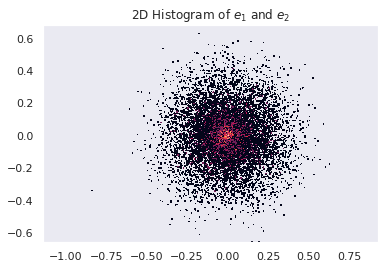

In [7]:
from matplotlib.colors import LogNorm 
plt.hist2d(shapes['All','e1'],shapes['All','e2'],bins=500,norm=LogNorm())
plt.axis('equal')
plt.title("2D Histogram of $e_1$ and $e_2$")
pd.Series(shapes['All','e1']).describe()
pd.Series(shapes['All','e2']).describe()

count    15374.000000
mean        -1.052036
std        170.275772
min     -20097.585018
25%         -1.007394
50%         -0.006972
75%          0.987162
max       3224.125134
dtype: float64

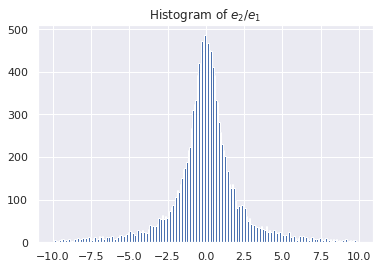

In [8]:
#statistics and hisgoram of e2/e1
plt.hist(shapes['All','e2']/shapes['All','e1'],bins=np.arange(-10,10,0.1))
plt.title("Histogram of $e_2$/$e_1$")
pd.Series(shapes['All','e2']/shapes['All','e1']).describe()

# Get phi 

In [9]:
def get_std_err_of_mean(np_array):
    mean=np_array.mean()
    std=np_array.std()
    n=len(np_array)
    return(std/np.sqrt(n))

In [10]:
def get_theta_for_obj(obj1,obj2):
    
    """Theta is the position angle of obj2 from north of east of obj1 """
    
    ra1,dec1=(obj1[('All', 'RA')],obj1[('All', 'DEC')])
    ra2,dec2=(obj2[('All', 'RA')],obj2[('All', 'DEC')])
    
    
    
    c1=SkyCoord(ra1*u.deg,dec1*u.deg)
    c2=SkyCoord(ra2*u.deg,dec2*u.deg)
    
    
    return(90-c1.position_angle(c2).degree)
    

In [11]:
def get_pa_for_obj(obj):
    e1=obj['All']['e1']
    e2=obj['All']['e1']
    
    α =0.5*np.arctan2(-e2,-e1)*180/np.pi
    return(α)

In [12]:
error_list_phi=[]
error_list_e=[]

def get_phi_for_cluster(cluster):
    
    """Input: cluster series
        Output: an array of position angle weighted by PP
        Record KeyError in an array (usually caused by uncomplete shape catalog).
    """
    
    try:
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]

        mem_match_id=cluster.name
        members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]



        pa=np.array([get_pa_for_obj(member[1]) for member in members.iterrows()]).flatten()
        theta= np.array([get_theta_for_obj(member[1],center) for member in members.iterrows()]).flatten()
        pp=members[('All','PP')]
        phi=(pa-theta)
        phi_w=(pa-theta)*pp
    #     print(center.index)
        return(phi,phi_w)    
    except KeyError as e:
        error_list_phi.append(e)
        return(np.array([]),np.array([]))

In [13]:
phi_list=[]
phi_w_list=[]
for mem_matching_id in tqdm(clusters.index):
    phi_array=get_phi_for_cluster(clusters.loc[mem_matching_id])[0]
    phi_w_array=get_phi_for_cluster(clusters.loc[mem_matching_id])[1]
    phi_w_list.append(phi_w_array)
    phi_list.append(phi_array)
phi_list=np.array(phi_list)
phi_w_list=np.array(phi_w_list)

In [14]:
def process_phi(phi_list):

    phi_1d=np.concatenate(phi_list)

    phi_1d=np.where(phi_1d<=0,-phi_1d,phi_1d)
    phi_1d=np.where(phi_1d>=180,phi_1d-180,phi_1d)
    phi_1d=np.where(phi_1d>=90,180-phi_1d,phi_1d)

    phi_1d=np.sort(phi_1d)
    
    return(phi_1d)

phi_1d=process_phi(phi_list)
phi_w_1d=process_phi(phi_w_list)

In [15]:
np.save("/home/cz136/project/sa/data/{}/phi_1d.npy".format(dir_string),phi_1d)
np.save("/home/cz136/project/sa/data/{}/phi_w_1d.npy".format(dir_string),phi_w_1d)

## Stats for unweighted 

In [16]:
# phi_1d=np.load("/home/cz136/project/sa/data/phi_1d.npy")
pd.Series(phi_1d).describe()
print("Mean:{:05e} \nStdE:{:05e} ".format(phi_1d.mean(),phi_1d.std()/np.sqrt(len(phi_1d))))

Mean:4.488885e+01 
StdE:2.099508e-01 


count    15374.000000
mean        44.888848
std         26.033055
min          0.000277
25%         22.500000
50%         44.998643
75%         67.500000
max         89.987996
dtype: float64

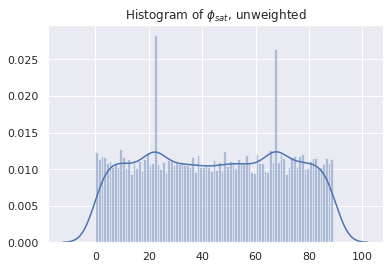

In [17]:
BINS=np.arange(0,90,1)
ax = sns.distplot(phi_1d,bins=BINS)
ax.set_title("Histogram of $\phi_{sat}$, unweighted") 
pd.Series(phi_1d).describe()

## Stats for weighted

In [18]:
pd.Series(phi_w_1d).describe()
print("Mean:{:05e} \nStdE:{:05e} ".format(phi_1d.mean(),phi_1d.std()/np.sqrt(len(phi_1d))))

Mean:4.488885e+01 
StdE:2.099508e-01 


count    15374.000000
mean        44.429642
std         25.833833
min          0.010829
25%         22.500000
50%         44.066296
75%         67.500000
max         89.997206
dtype: float64

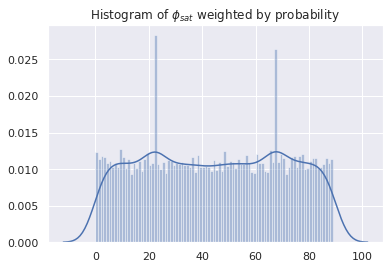

In [19]:
BINS=np.arange(0,90,1)
ax = sns.distplot(phi_1d,bins=BINS)
ax.set_title("Histogram of $\phi_{sat}$ weighted by probability") 
pd.Series(phi_w_1d).describe()

# Analysis around 22.5 and 67.5

In [20]:
#Print out the most crowded bins

phi_count=np.histogram(phi_1d,bins=BINS)
sort=np.argsort(-phi_count[0])
print(phi_count[1][sort])
print(phi_count[0][sort])

[22 67  9 65 48  0 19 69 60 77 56 38 74  2 76 36 10  3 73 81 82 86 70  1
 53 88 12 18 44 27 28  5 16 80 50 51 25 66 68 32 46 62 61 57 30 87  4 21
  7 14 31 54 55 23 85 33 34 20 29 49 41  6 39 40 72 35 42 84 75  8 11 83
 15 79 52 78 24 45 17 47 63 43 37 58 64 26 59 71 13]
[431 403 195 192 189 188 185 184 183 183 181 181 180 179 179 178 178 177
 177 176 176 176 175 174 173 173 173 173 172 172 170 170 170 169 169 168
 168 168 168 168 167 166 166 166 166 165 165 165 165 165 164 164 164 163
 162 161 161 161 160 159 158 157 157 157 157 156 156 156 156 156 155 155
 155 154 154 153 152 151 149 149 148 148 147 147 146 144 144 142 142]


count    431.000000
mean      22.492639
std        0.166395
min       22.001433
25%       22.500000
50%       22.500000
75%       22.500000
max       22.998843
dtype: float64

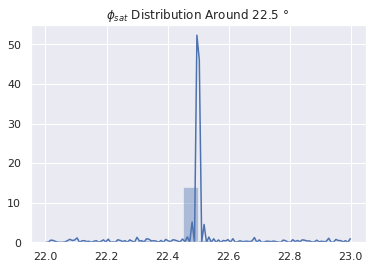

In [21]:
#Statistics around 22.5
first_cluster_left=np.sum(phi_count[0][0:22])
first_length=phi_count[0][sort][0]
first_cluster=phi_1d[first_cluster_left:first_cluster_left+first_length]
ax = sns.distplot(first_cluster)
ax.set_title("$\phi_{sat}$ Distribution Around 22.5 $\degree$")
pd.Series(first_cluster).describe()

count    431.000000
mean      67.536623
std        0.214945
min       67.018678
25%       67.500000
50%       67.500000
75%       67.500000
max       68.141099
dtype: float64

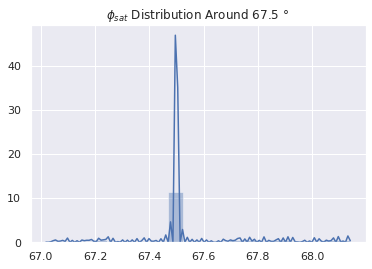

In [22]:
second_cluster_left=np.sum(phi_count[0][0:67])
second_length=phi_count[0][sort][0]
second_cluster=phi_1d[second_cluster_left:second_cluster_left+second_length]
ax = sns.distplot(second_cluster)
ax.set_title("$\phi_{sat}$ Distribution Around 67.5 $\degree$")
pd.Series(second_cluster).describe()

# Get e

## Statistics of e1 and e2

In [23]:
e1=shapes[('All','e1')].to_numpy()
shapes[('All','e1')].describe()

count    15374.000000
mean         0.000431
std          0.142445
min         -0.838272
25%         -0.073935
50%         -0.000909
75%          0.074437
max          0.629636
Name: (All, e1), dtype: float64

In [24]:
e2=shapes[('All','e1')].to_numpy()
shapes[('All','e2')].describe()

count    15374.000000
mean        -0.001151
std          0.144523
min         -0.659677
25%         -0.074782
50%         -0.000808
75%          0.073361
max          0.683530
Name: (All, e2), dtype: float64

In [25]:
def get_e_for_pair(cen,sat):
    e=np.sqrt(sat[('All','e1')]**2+sat[('All','e2')]**2)
    delta=get_theta_for_obj(cen,sat)
    alpha=get_pa_for_obj(sat)
    ep,ex=(e*np.cos(2*(delta-alpha)),e*np.sin(2*(delta-alpha)))
    return(ep,ex)

In [26]:
def get_e_for_cluster(cluster):
    
    try:
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]

        mem_match_id=cluster.name
        members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]

        e_array=np.array([(get_e_for_pair(center,member[1])) for member in members.iterrows()])
        return(e_array)    
    except KeyError as e:
        error_list_e.append(e)
        return(np.array([]))

In [27]:
e_list=[]
for mem_matching_id in tqdm(clusters.index[:]):
    e_array=get_e_for_cluster(clusters.loc[mem_matching_id])
    e_list.append(e_array)
e_list=np.array(e_list)
e_list=np.concatenate([e_array for e_array in e_list if e_array!=np.array([])])

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [28]:
np.save("/home/cz136/project/sa/data/{}/e_array".format(dir_string),e_list)

In [29]:
e_p_1d=e_list[:,0].flatten()
e_x_1d=e_list[:,1].flatten()

mean=-1.016924e-03, std_mean=1.162613e-03


count    15374.000000
mean        -0.001017
std          0.144159
min         -0.641451
25%         -0.076386
50%         -0.000137
75%          0.073117
max          0.684332
dtype: float64

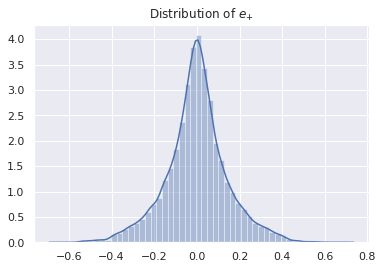

In [30]:
ax=sns.distplot(e_p_1d)
ax.set_title("Distribution of $e_{+}$")
print ("mean={:05e}, std_mean={:05e}".format(e_p_1d.mean(),get_std_err_of_mean(e_p_1d)))
pd.Series(e_p_1d).describe()

mean=5.403571e-04, std_mean=1.151760e-03


count    15374.000000
mean         0.000540
std          0.142814
min         -0.636614
25%         -0.071348
50%          0.004076
75%          0.073154
max          0.663913
dtype: float64

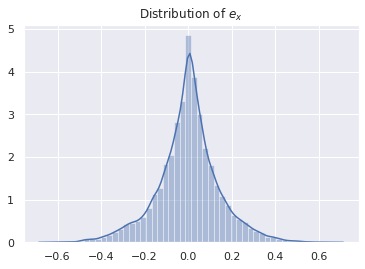

In [31]:
ax=sns.distplot(e_x_1d)
ax.set_title("Distribution of $e_{x}$")
print ("mean={:05e}, std_mean={:05e}".format(e_x_1d.mean(),get_std_err_of_mean(e_x_1d)))
pd.Series(e_x_1d).describe()